In [20]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


# Import packages
### Got rid of keras imports becasue I was getting version errors and instead using tf.keras (TF 2.5.0)

In [22]:
import tensorflow as tf
import pandas as pd

In [23]:
print(tf.version.VERSION)

2.5.0


In [24]:
data = pd.read_csv('bitcoin.csv').drop(['time_period_start', 'time_period_end', 'time_open', 'time_close'], axis=1)
data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,7165.72,7165.72,7165.71,7165.71,0.021841,2
1,7168.30,7168.30,7168.30,7168.30,1.000000,2
2,7170.50,7170.50,7170.50,7170.50,0.002000,1
3,7169.20,7169.20,7169.20,7169.20,0.004000,2
4,7169.20,7169.20,7169.20,7169.20,0.002000,1


## Lookback Window

In order to capture the past as features, we create the below function. It takes as input some number of seconds to look back, defaulted to 60 seconds.

In [25]:
def lookback(dataset, timesteps = 60):
    # this uses the shift method of pandas dataframes to shift all of the columns down one row
    # and then append to the original dataset
    data = dataset
    for i in range(1, timesteps):
        step_back = dataset.shift(i).reset_index()
        step_back.columns = ['index'] + [f'{column}_-{i}' for column in dataset.columns if column != 'index']
        data = data.reset_index().merge(step_back, on='index', ).drop('index', axis=1)
        
    return data.dropna()
        
features = lookback(data)

# Bad idea... data leakage

In [26]:
### split data into features and target
target = features['price_high'].values
features = features.drop('price_high', axis=1).values


# Create time series validation, train on beginning and validate on end
### (having a validation split parameter in fit would accomplish this as well but I wanted to define datasets)

In [27]:
train_idx = int(len(target) * 0.7)
num_features = features.shape[1]

x_train = features[:train_idx, :]
x_val = features[train_idx:, :]

y_train = target[:train_idx]
y_val = target[train_idx:]

print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(6958, 359) (2983, 359)
(6958,) (2983,)


# Turn numpy arrays into Tensors and create training and validation datasets

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset

<TensorSliceDataset shapes: ((359,), ()), types: (tf.float64, tf.float64)>

In [29]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset

<TensorSliceDataset shapes: ((359,), ()), types: (tf.float64, tf.float64)>

In [30]:
batch_size = 1024

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)


# Define Model
### Changes:
- Set random seed so we can have consistency with debugging and testing
- Flattened input to handle (N) vs (N, 1) shape mismatch
- Added relu activations at each layer, other wise just a linear function
- Changed loss to MAE, why think in squared?
- Reduced learing rate

In [31]:
tf.random.set_seed(
    42
)
model = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=(num_features,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=.00001), # is this the best optimizer/learning rate?
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mean_absolute_error'] # does accuracy make sense in this context?
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 359)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                11520     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 12,193
Trainable params: 12,193
Non-trainable params: 0
_________________________________________________________________


# Train the model
### Changes:
- got rid of early stopping callback and replaced with checkpoint to save the model with the best validation
- increased epochs due to smaller learning rate

In [35]:
!mkdir models

In [36]:
checkpoint_filepath = 'models/model_1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
history = model.fit(
    train_dataset,
    callbacks=[model_checkpoint_callback],
    validation_data = val_dataset,
    epochs=200,
    verbose='auto' # you want to see whats happening during training
)

Epoch 1/200
7/7 [==============================] - 0s 11ms/step - loss: 5285.7891 - root_mean_squared_error: 5285.8213 - mean_absolute_error: 5285.7891 - val_loss: 5237.8887 - val_root_mean_squared_error: 5237.8916 - val_mean_absolute_error: 5237.8887
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 5190.2295 - root_mean_squared_error: 5190.2632 - mean_absolute_error: 5190.2295 - val_loss: 5141.6411 - val_root_mean_squared_error: 5141.6450 - val_mean_absolute_error: 5141.6411
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 5092.4170 - root_mean_squared_error: 5092.4551 - mean_absolute_error: 5092.4170 - val_loss: 5041.3438 - val_root_mean_squared_error: 5041.3477 - val_mean_absolute_error: 5041.3438
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 4/200
7/7 [==============================] - 0s 11ms/step - loss: 4

7/7 [==============================] - 0s 12ms/step - loss: 3382.1306 - root_mean_squared_error: 3382.1523 - mean_absolute_error: 3382.1306 - val_loss: 3351.1638 - val_root_mean_squared_error: 3351.1665 - val_mean_absolute_error: 3351.1638
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 28/200
7/7 [==============================] - 0s 10ms/step - loss: 3320.5691 - root_mean_squared_error: 3320.5918 - mean_absolute_error: 3320.5691 - val_loss: 3289.3442 - val_root_mean_squared_error: 3289.3467 - val_mean_absolute_error: 3289.3442
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 29/200
7/7 [==============================] - 0s 14ms/step - loss: 3258.7300 - root_mean_squared_error: 3258.7537 - mean_absolute_error: 3258.7300 - val_loss: 3227.2432 - val_root_mean_squared_error: 3227.2456 - val_mean_absolute_error: 3227.2432
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 30/200
7/7 [==============================] - 0s 10ms/step - loss: 3196.6072 

7/7 [==============================] - 0s 10ms/step - loss: 1676.2347 - root_mean_squared_error: 1676.3186 - mean_absolute_error: 1676.2347 - val_loss: 1637.3458 - val_root_mean_squared_error: 1637.3483 - val_mean_absolute_error: 1637.3458
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 54/200
7/7 [==============================] - 0s 11ms/step - loss: 1605.6481 - root_mean_squared_error: 1605.7382 - mean_absolute_error: 1605.6481 - val_loss: 1566.4100 - val_root_mean_squared_error: 1566.4126 - val_mean_absolute_error: 1566.4100
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 55/200
7/7 [==============================] - 0s 10ms/step - loss: 1534.6501 - root_mean_squared_error: 1534.7471 - mean_absolute_error: 1534.6501 - val_loss: 1495.0585 - val_root_mean_squared_error: 1495.0612 - val_mean_absolute_error: 1495.0585
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 56/200
7/7 [==============================] - 0s 15ms/step - loss: 1463.2380 

7/7 [==============================] - 0s 15ms/step - loss: 4.2070 - root_mean_squared_error: 4.9674 - mean_absolute_error: 4.2070 - val_loss: 2.9522 - val_root_mean_squared_error: 3.4051 - val_mean_absolute_error: 2.9522
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 81/200
7/7 [==============================] - 0s 10ms/step - loss: 3.3917 - root_mean_squared_error: 4.0590 - mean_absolute_error: 3.3917 - val_loss: 1.5501 - val_root_mean_squared_error: 2.2355 - val_mean_absolute_error: 1.5501
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 82/200
7/7 [==============================] - 0s 10ms/step - loss: 2.7142 - root_mean_squared_error: 3.5872 - mean_absolute_error: 2.7142 - val_loss: 2.5154 - val_root_mean_squared_error: 3.0762 - val_mean_absolute_error: 2.5154
Epoch 83/200
7/7 [==============================] - 0s 9ms/step - loss: 2.3037 - root_mean_squared_error: 2.9987 - mean_absolute_error: 2.3037 - val_loss: 1.7315 - val_root_mean_squared_error: 2

7/7 [==============================] - 0s 9ms/step - loss: 2.0701 - root_mean_squared_error: 2.8828 - mean_absolute_error: 2.0701 - val_loss: 1.6378 - val_root_mean_squared_error: 2.2761 - val_mean_absolute_error: 1.6378
Epoch 115/200
7/7 [==============================] - 0s 10ms/step - loss: 2.0735 - root_mean_squared_error: 2.8867 - mean_absolute_error: 2.0735 - val_loss: 1.6396 - val_root_mean_squared_error: 2.2773 - val_mean_absolute_error: 1.6396
Epoch 116/200
7/7 [==============================] - 0s 10ms/step - loss: 2.0754 - root_mean_squared_error: 2.8887 - mean_absolute_error: 2.0754 - val_loss: 1.6434 - val_root_mean_squared_error: 2.2797 - val_mean_absolute_error: 1.6434
Epoch 117/200
7/7 [==============================] - 0s 10ms/step - loss: 2.0778 - root_mean_squared_error: 2.8905 - mean_absolute_error: 2.0778 - val_loss: 1.6494 - val_root_mean_squared_error: 2.2835 - val_mean_absolute_error: 1.6494
Epoch 118/200
7/7 [==============================] - 0s 10ms/step - los

Epoch 149/200
7/7 [==============================] - 0s 11ms/step - loss: 2.1797 - root_mean_squared_error: 2.9845 - mean_absolute_error: 2.1797 - val_loss: 1.7704 - val_root_mean_squared_error: 2.3650 - val_mean_absolute_error: 1.7704
Epoch 150/200
7/7 [==============================] - 0s 11ms/step - loss: 2.1822 - root_mean_squared_error: 2.9859 - mean_absolute_error: 2.1822 - val_loss: 1.7744 - val_root_mean_squared_error: 2.3678 - val_mean_absolute_error: 1.7744
Epoch 151/200
7/7 [==============================] - 0s 10ms/step - loss: 2.1864 - root_mean_squared_error: 2.9901 - mean_absolute_error: 2.1864 - val_loss: 1.7783 - val_root_mean_squared_error: 2.3706 - val_mean_absolute_error: 1.7783
Epoch 152/200
7/7 [==============================] - 0s 9ms/step - loss: 2.1879 - root_mean_squared_error: 2.9926 - mean_absolute_error: 2.1879 - val_loss: 1.7774 - val_root_mean_squared_error: 2.3699 - val_mean_absolute_error: 1.7774
Epoch 153/200
7/7 [==============================] - 0s 1

Epoch 184/200
7/7 [==============================] - 0s 10ms/step - loss: 2.2667 - root_mean_squared_error: 3.0627 - mean_absolute_error: 2.2667 - val_loss: 1.9147 - val_root_mean_squared_error: 2.4718 - val_mean_absolute_error: 1.9147
Epoch 185/200
7/7 [==============================] - 0s 10ms/step - loss: 2.2644 - root_mean_squared_error: 3.0606 - mean_absolute_error: 2.2644 - val_loss: 1.9295 - val_root_mean_squared_error: 2.4833 - val_mean_absolute_error: 1.9295
Epoch 186/200
7/7 [==============================] - 0s 11ms/step - loss: 2.2728 - root_mean_squared_error: 3.0677 - mean_absolute_error: 2.2728 - val_loss: 1.9222 - val_root_mean_squared_error: 2.4777 - val_mean_absolute_error: 1.9222
Epoch 187/200
7/7 [==============================] - 0s 10ms/step - loss: 2.2709 - root_mean_squared_error: 3.0670 - mean_absolute_error: 2.2709 - val_loss: 1.9194 - val_root_mean_squared_error: 2.4755 - val_mean_absolute_error: 1.9194
Epoch 188/200
7/7 [==============================] - 0s 

# Plot results

<IPython.core.display.Javascript object>


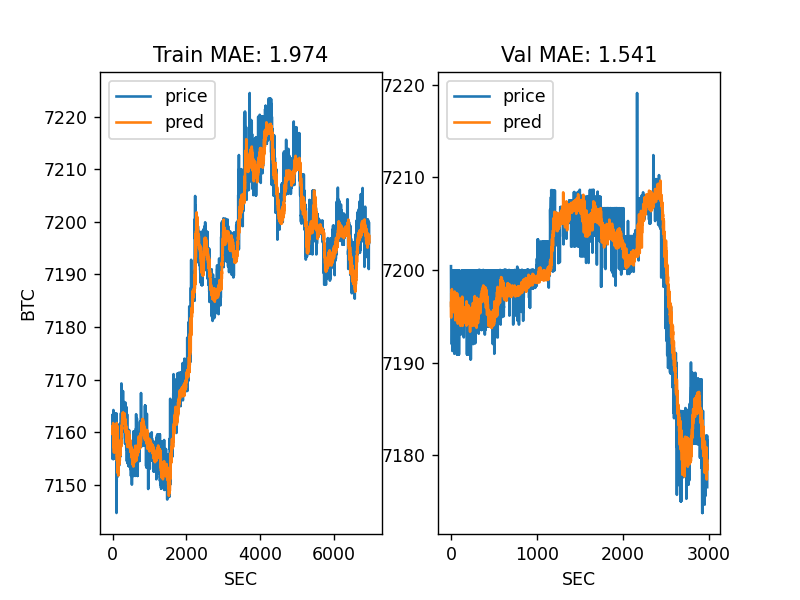

Text(0.5, 1.0, 'Val MAE: 1.541')

In [37]:
model.load_weights(checkpoint_filepath)

figure()

subplot(1, 2, 1)
train_pred = model.predict(train_dataset).flatten()
plot(y_train, label='price')
plot(train_pred, label='pred')
legend()
xlabel('SEC')
ylabel('BTC')
title(f'Train MAE: {round(np.mean(np.abs(y_train - train_pred)), 3)}')

subplot(1, 2, 2)
val_pred = model.predict(val_dataset).flatten()
plot(y_val,label='price')
plot(val_pred, label='pred')
legend()
xlabel('SEC')
#ylabel('BTC')
title(f'Val MAE: {round(np.mean(np.abs(y_val - val_pred)), 3)}')

In [38]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

<IPython.core.display.Javascript object>


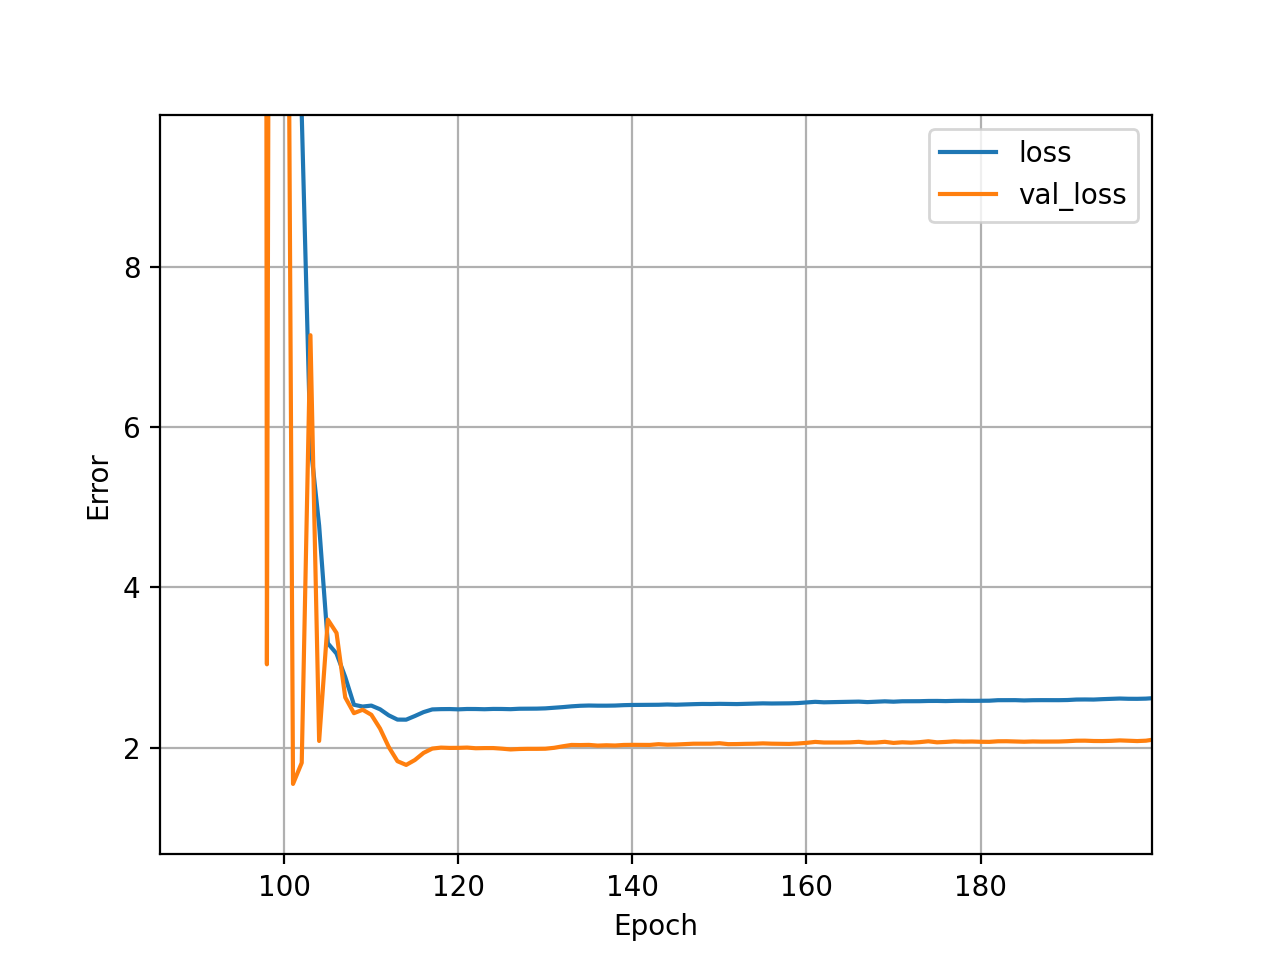

In [241]:
figure()
plot_loss(history)

# Now remove data leakage


In [39]:
features = lookback(data)
features.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,price_open_-1,price_high_-1,price_low_-1,price_close_-1,...,price_low_-58,price_close_-58,volume_traded_-58,trades_count_-58,price_open_-59,price_high_-59,price_low_-59,price_close_-59,volume_traded_-59,trades_count_-59
59,7154.97,7154.97,7154.97,7154.97,2.000000,2,7163.30,7163.30,7163.30,7163.30,...,7168.30,7168.3,1.000000,2.0,7165.72,7165.72,7165.71,7165.71,0.021841,2.0
60,7161.20,7163.40,7161.20,7163.40,0.015800,2,7154.97,7154.97,7154.97,7154.97,...,7170.50,7170.5,0.002000,1.0,7168.30,7168.30,7168.30,7168.30,1.000000,2.0
61,7154.98,7154.98,7154.97,7154.98,0.038357,3,7161.20,7163.40,7161.20,7163.40,...,7169.20,7169.2,0.004000,2.0,7170.50,7170.50,7170.50,7170.50,0.002000,1.0
62,7154.98,7154.98,7154.98,7154.98,0.032201,1,7154.98,7154.98,7154.97,7154.98,...,7169.20,7169.2,0.002000,1.0,7169.20,7169.20,7169.20,7169.20,0.004000,2.0
63,7154.97,7154.97,7154.97,7154.97,2.000000,1,7154.98,7154.98,7154.98,7154.98,...,7165.72,7169.2,0.075433,3.0,7169.20,7169.20,7169.20,7169.20,0.002000,1.0


In [41]:
### split data into features and target
target = features['price_high'].values
features = features.drop([
    'price_high',
    'price_open',
    'price_low',
    'price_close',
    'volume_traded',
    'trades_count'
], axis=1).values

In [43]:
train_idx = int(len(target) * 0.7)
num_features = features.shape[1]

x_train = features[:train_idx, :]
x_val = features[train_idx:, :]

y_train = target[:train_idx]
y_val = target[train_idx:]

print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 1024

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

tf.random.set_seed(
    42
)
model = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=(num_features,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=.00001), # is this the best optimizer/learning rate?
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mean_absolute_error'] # does accuracy make sense in this context?
)

checkpoint_filepath = 'models/model_just_past'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
history = model.fit(
    train_dataset,
    callbacks=[model_checkpoint_callback],
    validation_data = val_dataset,
    epochs=200,
    verbose='auto' # you want to see whats happening during training
)

model.load_weights(checkpoint_filepath)



(6958, 354) (2983, 354)
(6958,) (2983,)
Epoch 1/200
7/7 [==============================] - 1s 26ms/step - loss: 3396.3171 - root_mean_squared_error: 3396.4321 - mean_absolute_error: 3396.3171 - val_loss: 3329.6606 - val_root_mean_squared_error: 3329.6628 - val_mean_absolute_error: 3329.6606
INFO:tensorflow:Assets written to: models\model_just_past\assets
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 3273.6907 - root_mean_squared_error: 3273.8118 - mean_absolute_error: 3273.6907 - val_loss: 3206.8521 - val_root_mean_squared_error: 3206.8545 - val_mean_absolute_error: 3206.8521
INFO:tensorflow:Assets written to: models\model_just_past\assets
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 3151.0747 - root_mean_squared_error: 3151.2026 - mean_absolute_error: 3151.0747 - val_loss: 3084.0459 - val_root_mean_squared_error: 3084.0481 - val_mean_absolute_error: 3084.0459
INFO:tensorflow:Assets written to: models\model_just_past\assets
Epoch 4/2

7/7 [==============================] - 0s 11ms/step - loss: 3028.4565 - root_mean_squared_error: 3028.5913 - mean_absolute_error: 3028.4565 - val_loss: 2961.2253 - val_root_mean_squared_error: 2961.2273 - val_mean_absolute_error: 2961.2253
INFO:tensorflow:Assets written to: models\model_just_past\assets
Epoch 5/200
7/7 [==============================] - 0s 12ms/step - loss: 2905.8142 - root_mean_squared_error: 2905.9573 - mean_absolute_error: 2905.8142 - val_loss: 2838.3699 - val_root_mean_squared_error: 2838.3718 - val_mean_absolute_error: 2838.3699
INFO:tensorflow:Assets written to: models\model_just_past\assets
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 2783.1313 - root_mean_squared_error: 2783.2830 - mean_absolute_error: 2783.1313 - val_loss: 2716.1602 - val_root_mean_squared_error: 2716.1621 - val_mean_absolute_error: 2716.1602
INFO:tensorflow:Assets written to: models\model_just_past\assets
Epoch 7/200
7/7 [==============================] - 0s 11ms/st

Epoch 30/200
7/7 [==============================] - 0s 15ms/step - loss: 46.5431 - root_mean_squared_error: 54.7288 - mean_absolute_error: 46.5431 - val_loss: 13.0207 - val_root_mean_squared_error: 13.1750 - val_mean_absolute_error: 13.0207
INFO:tensorflow:Assets written to: models\model_just_past\assets
Epoch 31/200
7/7 [==============================] - 0s 13ms/step - loss: 33.2663 - root_mean_squared_error: 35.1476 - mean_absolute_error: 33.2663 - val_loss: 43.0707 - val_root_mean_squared_error: 43.1183 - val_mean_absolute_error: 43.0707
Epoch 32/200
7/7 [==============================] - 0s 13ms/step - loss: 29.9798 - root_mean_squared_error: 31.7462 - mean_absolute_error: 29.9798 - val_loss: 3.4573 - val_root_mean_squared_error: 3.8632 - val_mean_absolute_error: 3.4573
INFO:tensorflow:Assets written to: models\model_just_past\assets
Epoch 33/200
7/7 [==============================] - 0s 12ms/step - loss: 13.1876 - root_mean_squared_error: 14.6724 - mean_absolute_error: 13.1876 - v

Epoch 64/200
7/7 [==============================] - 0s 11ms/step - loss: 2.3005 - root_mean_squared_error: 3.0376 - mean_absolute_error: 2.3005 - val_loss: 1.8805 - val_root_mean_squared_error: 2.4277 - val_mean_absolute_error: 1.8805
Epoch 65/200
7/7 [==============================] - 0s 11ms/step - loss: 2.3040 - root_mean_squared_error: 3.0402 - mean_absolute_error: 2.3040 - val_loss: 1.8893 - val_root_mean_squared_error: 2.4350 - val_mean_absolute_error: 1.8893
Epoch 66/200
7/7 [==============================] - 0s 11ms/step - loss: 2.3113 - root_mean_squared_error: 3.0470 - mean_absolute_error: 2.3113 - val_loss: 1.8993 - val_root_mean_squared_error: 2.4434 - val_mean_absolute_error: 1.8993
Epoch 67/200
7/7 [==============================] - 0s 11ms/step - loss: 2.3170 - root_mean_squared_error: 3.0523 - mean_absolute_error: 2.3170 - val_loss: 1.9115 - val_root_mean_squared_error: 2.4538 - val_mean_absolute_error: 1.9115
Epoch 68/200
7/7 [==============================] - 0s 12ms/

Epoch 99/200
7/7 [==============================] - 0s 12ms/step - loss: 2.4573 - root_mean_squared_error: 3.1780 - mean_absolute_error: 2.4573 - val_loss: 2.1065 - val_root_mean_squared_error: 2.6220 - val_mean_absolute_error: 2.1065
Epoch 100/200
7/7 [==============================] - 0s 11ms/step - loss: 2.4644 - root_mean_squared_error: 3.1843 - mean_absolute_error: 2.4644 - val_loss: 2.1079 - val_root_mean_squared_error: 2.6232 - val_mean_absolute_error: 2.1079
Epoch 101/200
7/7 [==============================] - 0s 12ms/step - loss: 2.4674 - root_mean_squared_error: 3.1868 - mean_absolute_error: 2.4674 - val_loss: 2.1047 - val_root_mean_squared_error: 2.6204 - val_mean_absolute_error: 2.1047
Epoch 102/200
7/7 [==============================] - 0s 12ms/step - loss: 2.4678 - root_mean_squared_error: 3.1871 - mean_absolute_error: 2.4678 - val_loss: 2.1096 - val_root_mean_squared_error: 2.6247 - val_mean_absolute_error: 2.1096
Epoch 103/200
7/7 [==============================] - 0s 1

Epoch 134/200
7/7 [==============================] - 0s 12ms/step - loss: 2.5323 - root_mean_squared_error: 3.2475 - mean_absolute_error: 2.5323 - val_loss: 2.2208 - val_root_mean_squared_error: 2.7234 - val_mean_absolute_error: 2.2208
Epoch 135/200
7/7 [==============================] - 0s 11ms/step - loss: 2.5331 - root_mean_squared_error: 3.2475 - mean_absolute_error: 2.5331 - val_loss: 2.2249 - val_root_mean_squared_error: 2.7272 - val_mean_absolute_error: 2.2249
Epoch 136/200
7/7 [==============================] - 0s 11ms/step - loss: 2.5345 - root_mean_squared_error: 3.2495 - mean_absolute_error: 2.5345 - val_loss: 2.2249 - val_root_mean_squared_error: 2.7271 - val_mean_absolute_error: 2.2249
Epoch 137/200
7/7 [==============================] - 0s 12ms/step - loss: 2.5358 - root_mean_squared_error: 3.2502 - mean_absolute_error: 2.5358 - val_loss: 2.2266 - val_root_mean_squared_error: 2.7287 - val_mean_absolute_error: 2.2266
Epoch 138/200
7/7 [==============================] - 0s 

Epoch 169/200
7/7 [==============================] - 0s 12ms/step - loss: 2.5629 - root_mean_squared_error: 3.2753 - mean_absolute_error: 2.5629 - val_loss: 2.2769 - val_root_mean_squared_error: 2.7736 - val_mean_absolute_error: 2.2769
Epoch 170/200
7/7 [==============================] - 0s 10ms/step - loss: 2.5664 - root_mean_squared_error: 3.2780 - mean_absolute_error: 2.5664 - val_loss: 2.2786 - val_root_mean_squared_error: 2.7751 - val_mean_absolute_error: 2.2786
Epoch 171/200
7/7 [==============================] - 0s 11ms/step - loss: 2.5667 - root_mean_squared_error: 3.2788 - mean_absolute_error: 2.5667 - val_loss: 2.2778 - val_root_mean_squared_error: 2.7743 - val_mean_absolute_error: 2.2778
Epoch 172/200
7/7 [==============================] - 0s 10ms/step - loss: 2.5656 - root_mean_squared_error: 3.2778 - mean_absolute_error: 2.5656 - val_loss: 2.2787 - val_root_mean_squared_error: 2.7752 - val_mean_absolute_error: 2.2787
Epoch 173/200
7/7 [==============================] - 0s 

<IPython.core.display.Javascript object>


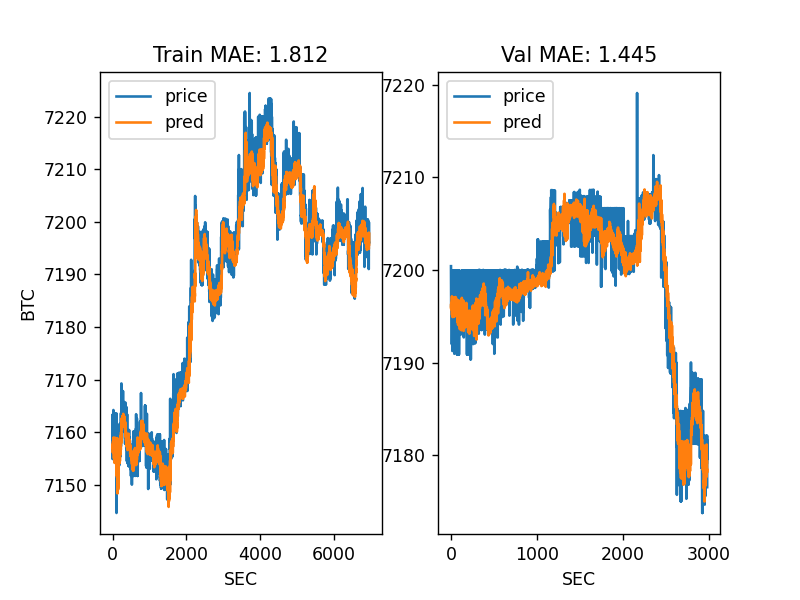

Text(0.5, 1.0, 'Val MAE: 1.445')

In [44]:
figure()

subplot(1, 2, 1)
train_pred = model.predict(train_dataset).flatten()
plot(y_train, label='price')
plot(train_pred, label='pred')
legend()
xlabel('SEC')
ylabel('BTC')
title(f'Train MAE: {round(np.mean(np.abs(y_train - train_pred)), 3)}')

subplot(1, 2, 2)
val_pred = model.predict(val_dataset).flatten()
plot(y_val,label='price')
plot(val_pred, label='pred')
legend()
xlabel('SEC')
#ylabel('BTC')
title(f'Val MAE: {round(np.mean(np.abs(y_val - val_pred)), 3)}')

# Interesting that the results are slightly better
### Perhaps this means that low, high, opening, and closing are susceptible to noise? Maybe and average per second might be a better indicator? Or is the change not significant enough?

# TODO and Next Steps:
- Try to predict based on average
- Can we incorporate other data sets to help predict?
- Try different models:
    - 1-D CNN
    - RNN/LSTM
    - LGBM Regressor
- In all the steps above use time series cross validation